In [1]:
# Implement robust parsers and produce summaries/plots again

import pandas as pd, numpy as np, re
from io import StringIO
import matplotlib.pyplot as plt

def parse_docker_stats_robust(path):
    # Try encodings
    txt = None
    for enc in ["utf-8", "utf-16", "utf-16le", "utf-16be"]:
        try:
            with open(path, "r", encoding=enc, errors="strict") as f:
                txt = f.read()
                break
        except Exception:
            continue
    if txt is None:
        with open(path, "rb") as f:
            raw = f.read()
        # fallback: strip nulls and decode as latin-1
        txt = raw.decode("latin-1").replace("\x00", "")
    lines = [ln.strip() for ln in txt.splitlines() if ln.strip()]
    rows = []
    unit_map = {"B":1, "kB":1e3, "KB":1e3, "MB":1e6, "MiB":1024**2, "GB":1e9, "GiB":1024**3}
    for line in lines:
        parts = [p.strip() for p in line.split(",")]
        if len(parts) < 5: 
            continue
        cpu_str, mem_usage, mem_pct_str, net_io, block_io = parts[:5]
        # CPU
        try:
            cpu_percent = float(cpu_str.strip("%"))
        except:
            continue
        # MemUsage "x / y"
        if "/" not in mem_usage: 
            continue
        a,b = [x.strip() for x in mem_usage.split("/")[:2]]
        def to_bytes(s):
            m = re.findall(r"([\d\.]+)\s*([A-Za-z]+)", s)
            if not m: return np.nan
            v,u = m[0]
            return float(v) * unit_map.get(u, np.nan)
        mem_used_bytes = to_bytes(a)
        mem_total_bytes= to_bytes(b)
        try:
            mem_percent = float(mem_pct_str.strip("%"))
        except:
            mem_percent = np.nan
        # IO parsing
        def parse_io(io_str):
            if "/" not in io_str: return (np.nan, np.nan)
            x,y = [s.strip() for s in io_str.split("/")[:2]]
            return to_bytes(x), to_bytes(y)
        net_in, net_out = parse_io(net_io)
        block_in, block_out = parse_io(block_io)
        rows.append(dict(
            cpu_percent=cpu_percent,
            mem_used_gib=mem_used_bytes/(1024**3) if pd.notna(mem_used_bytes) else np.nan,
            mem_total_gib=mem_total_bytes/(1024**3) if pd.notna(mem_total_bytes) else np.nan,
            mem_percent=mem_percent,
            net_in_bytes=net_in, net_out_bytes=net_out,
            block_in_bytes=block_in, block_out_bytes=block_out
        ))
    return pd.DataFrame(rows)

def parse_gpu_dmon_robust(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = [ln.rstrip("\n") for ln in f if ln.strip()]
    # keep header line (the one not starting with '//' but starting with '#Date')
    header_line = None
    data_lines = []
    for ln in lines:
        if ln.startswith("#Date"):
            header_line = ln.lstrip("#")
            continue
        if ln.startswith("#"):
            continue
        data_lines.append(ln)
    if header_line is None:
        # fallback: assume first non-comment line already has columns
        header_line = re.sub(r"^#+","", lines[0])
    # Build whitespace-delimited CSV
    content = header_line + "\n" + "\n".join(data_lines) + "\n"
    df = pd.read_csv(StringIO(content), delim_whitespace=True)
    # Normalize column names
    df.columns = [c.strip().lower() for c in df.columns]
    return df

C:\Users\33387\AppData\Local\Temp\ipykernel_21232\1341774650.py:85: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(StringIO(content), delim_whitespace=True)


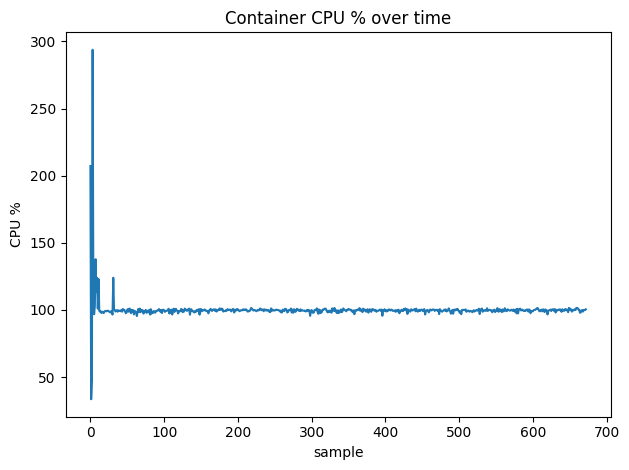

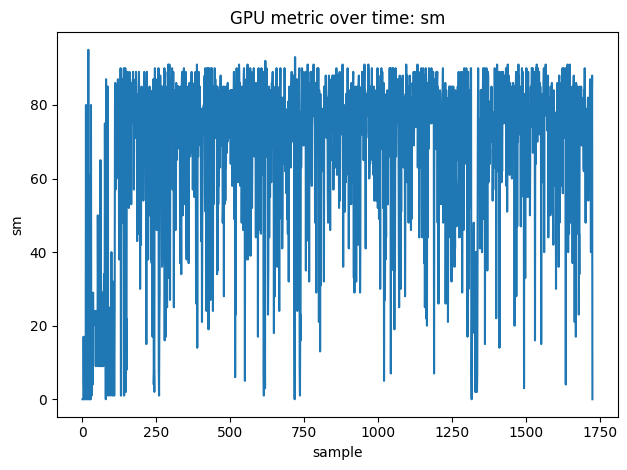

(   cpu_percent  mem_used_gib  mem_total_gib  mem_percent  net_in_bytes  \
 0       207.16      0.211816          7.675         2.76         529.0   
 1        33.44      0.581836          7.675         7.58        1050.0   
 2        49.43      0.965137          7.675        12.58        1090.0   
 3       293.73      1.466000          7.675        19.10        1090.0   
 4       104.28      1.930000          7.675        25.15        1090.0   
 
    net_out_bytes  block_in_bytes  block_out_bytes  
 0           84.0             0.0              0.0  
 1          126.0             0.0              0.0  
 2          168.0             0.0              0.0  
 3          168.0             0.0              0.0  
 4          168.0             0.0              0.0  ,
        date      time  gpu  pwr  gtemp mtemp  sm  mem  enc  dec  jpg  ofa  \
 0  20250921  06:16:49    0   24     36     -   0    0    0    0    0    0   
 1  20250921  06:16:50    0   18     35     -   0    4    0    0    0    

In [2]:
docker_stats_path = "logs/docker_stats_after.csv"
gpu_dmon_path = "logs/gpu_after.csv"

docker_df = parse_docker_stats_robust(docker_stats_path)
gpu_df = parse_gpu_dmon_robust(gpu_dmon_path)

# Compute summaries
jobs_per_sec = 0.55
p50 = 1238.46
p90 = 2473.76
p95 = 2924.54
p99 = 3487.85
elapsed_sec = 1814.3
total = 1000
errors = 0
unexpected = 1000

summary = {
    "Throughput (jobs/s)": jobs_per_sec,
    "Latency p50/p90/p95/p99 (ms)": f"{p50}/{p90}/{p95}/{p99}",
    "Total/Elapsed (s)": f"{total}/{elapsed_sec}",
    "Errors/Unexpected": f"{errors}/{unexpected}",
}

if not docker_df.empty:
    summary.update({
        "Container CPU avg (%)": round(docker_df["cpu_percent"].mean(),2),
        "Container CPU p95 (%)": round(docker_df["cpu_percent"].quantile(0.95),2),
        "Container Mem avg (GiB)": round(docker_df["mem_used_gib"].mean(),2),
        "Container Mem max (GiB)": round(docker_df["mem_used_gib"].max(),2),
        "Container Mem avg (%)": round(docker_df["mem_percent"].mean(),2),
    })

if not gpu_df.empty:
    # Choose columns
    # try common names
    candidates = {
        "power": [c for c in gpu_df.columns if c in ["pwr","power","pwr.w"] or "pwr" in c],
        "sm": [c for c in gpu_df.columns if c=="sm" or c.startswith("sm")],
        "mem_util": [c for c in gpu_df.columns if c=="mem" or c.startswith("mem")],
        "temp": [c for c in gpu_df.columns if c in ["gtemp","temp","t","tmp"]]
    }
    power_col = candidates["power"][0] if candidates["power"] else None
    sm_col = candidates["sm"][0] if candidates["sm"] else None
    memu_col = candidates["mem_util"][0] if candidates["mem_util"] else None
    temp_col = candidates["temp"][0] if candidates["temp"] else None

    if power_col:
        summary["GPU Power avg/max (W)"] = f"{round(gpu_df[power_col].mean(),1)}/{round(gpu_df[power_col].max(),1)}"
    if sm_col:
        summary["GPU SM util avg/p95 (%)"] = f"{round(gpu_df[sm_col].mean(),1)}/{round(gpu_df[sm_col].quantile(0.95),1)}"
    if memu_col:
        summary["GPU Mem util avg/p95 (%)"] = f"{round(gpu_df[memu_col].mean(),1)}/{round(gpu_df[memu_col].quantile(0.95),1)}"
    if temp_col:
        summary["GPU Temp avg/max (C)"] = f"{round(gpu_df[temp_col].mean(),1)}/{round(gpu_df[temp_col].max(),1)}"

summary_df = pd.DataFrame(list(summary.items()), columns=["metric","value"])

# Plots
if not docker_df.empty:
    plt.figure()
    docker_df["cpu_percent"].plot(title="Container CPU % over time")
    plt.xlabel("sample"); plt.ylabel("CPU %"); plt.tight_layout(); plt.show()

if not gpu_df.empty:
    # Prefer SM utilization if present
    plot_col = None
    if "sm" in gpu_df.columns: plot_col = "sm"
    else:
        for c in gpu_df.columns:
            if pd.api.types.is_numeric_dtype(gpu_df[c]):
                plot_col = c; break
    if plot_col:
        plt.figure()
        gpu_df[plot_col].plot(title=f"GPU metric over time: {plot_col}")
        plt.xlabel("sample"); plt.ylabel(plot_col); plt.tight_layout(); plt.show()

# Return heads for debugging to the notebook output
docker_df.head(5), gpu_df.head(5)

In [3]:
summary

{'Throughput (jobs/s)': 0.55,
 'Latency p50/p90/p95/p99 (ms)': '1238.46/2473.76/2924.54/3487.85',
 'Total/Elapsed (s)': '1000/1814.3',
 'Errors/Unexpected': '0/1000',
 'Container CPU avg (%)': np.float64(99.97),
 'Container CPU p95 (%)': np.float64(100.99),
 'Container Mem avg (GiB)': np.float64(2.28),
 'Container Mem max (GiB)': np.float64(2.31),
 'Container Mem avg (%)': np.float64(29.65),
 'GPU Power avg/max (W)': '89.5/120',
 'GPU SM util avg/p95 (%)': '67.7/90.0',
 'GPU Mem util avg/p95 (%)': '37.8/56.0',
 'GPU Temp avg/max (C)': '55.4/62'}